## IdentifyEmbeddingGroupings
This script:
- Loads the pickle file containing each sample point, the list of image files, the list of embeddings and the list of similarity scores
- Converts it so that each image (and associated embedding/scores) is its own row
- Removes some outlying images:
    - This stage may not be necessary, but does effectively remove images of both inside of buildings and inside of cars.
    - This is based on using UMAP to reduce the dimensionality of embeddings to 2, and then plotting in 2-dimensional space.
    There are two very clearly separated clusters of points which when I looked at the images within them, were those inside the cars and inside the buildings
- Cluster analysis:
    - Test whether there is a structure within the embeddings that would allow them to be broken down into sub-clusters
        - Silhouette scores (are scores higher than 1?)
        - Elbow scores
        - Adjusted Rand Index
    - Decide on the optimal K
    - Run a K-mean cluster analysis with optimal K

In [5]:
import pickle
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
from math import ceil
from PIL import Image
import umap
import random
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from functions import *

In [6]:
data_dir = os.path.join("../../../../data/embeddings/")
lsoas_file = os.path.join("../../../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")

### Get spatial data

In [7]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

### Get embeddings (four per location)

In [8]:
points_data_cache = data_dir + f"sample_points_cache/points_data_cache_with_CLIP_embeddings_and_scores_planninguseclasses.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [9]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_lsoa, how='inner', predicate='within')

# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


# Expand dataframe so there is one row per image

In [10]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embedding']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths
    cat_scores = row['category_scores']        # list of 4 image paths
    
    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embedding, {len(images)} images")
        continue

    for score, emb, img in zip(cat_scores, embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embedding'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        new_row['category_scores'] = score
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)

Skipping row 9158: 3 embedding, 4 images
Skipping row 18664: 3 embedding, 4 images
Original rows: 18897, Expanded rows: 75580


# Remove inside cars and inside buildings images
This stage is potentially not necessary?

In [11]:
# # Example wrapper if you have a dataframe
# embeddings = np.vstack(expanded_gdf["embedding"].values)   # shape (N, 512)
#              # string labels
# reducer = umap.UMAP(
#     n_neighbors=30, 
#     min_dist=0.1, 
#     metric='cosine',   # ✔ recommended for CLIP embeddings
#     random_state=42)

# emb_2d = reducer.fit_transform(embeddings)  # shape (N, 2)

# expanded_gdf['umap_x'] = emb_2d[:, 0]
# expanded_gdf['umap_y'] = emb_2d[:, 1]

In [12]:
# # ---------------------------------------------------------
# # 2. Define MULTIPLE bounding boxes
# #    Format: (x_min, x_max, y_min, y_max)
# # ---------------------------------------------------------
# bounding_boxes = [(5.7, 6.3, 9.5, 10),     # Box 1
#                   (2.3, 3.2, 8.5,9)]

# # ---------------------------------------------------------
# # 3. Build mask for ANY point inside ANY box
# # ---------------------------------------------------------
# inside_any_box = np.zeros(len(expanded_gdf), dtype=bool)

# for (x_min, x_max, y_min, y_max) in bounding_boxes:
#     inside_this_box = (
#         (expanded_gdf["umap_x"] >= x_min) & (expanded_gdf["umap_x"] <= x_max) &
#         (expanded_gdf["umap_y"] >= y_min) & (expanded_gdf["umap_y"] <= y_max))
#     inside_any_box |= inside_this_box      # combine masks

# # ---------------------------------------------------------
# # 4. Remove all points inside any bounding box
# # ---------------------------------------------------------
# expanded_gdf_filtered = expanded_gdf[~inside_any_box].copy()

# # ---------------------------------------------------------
# # 5. Visual sanity check
# # ---------------------------------------------------------
# plt.figure(figsize=(4, 3))

# # Points kept
# plt.scatter(expanded_gdf_filtered["umap_x"], expanded_gdf_filtered["umap_y"], s=2, alpha=0.25, label="kept")

# # Points removed
# plt.scatter(expanded_gdf.loc[inside_any_box, "umap_x"], expanded_gdf.loc[inside_any_box, "umap_y"], s=10, color="red",
#             label="removed")

# # Draw rectangles on the plot
# ax = plt.gca()
# for (x_min, x_max, y_min, y_max) in bounding_boxes:
#     rect = plt.Rectangle((x_min, y_min),x_max - x_min,y_max - y_min,linewidth=2,edgecolor="black", facecolor="none")
#     ax.add_patch(rect)

# plt.legend()
# plt.title("UMAP with Multiple Removed Bounding Boxes")
# plt.tight_layout()
# plt.show()

# # (Optional) overwrite original:
# expanded_gdf = expanded_gdf_filtered.copy()

# Test optimal cluster numbers

In [13]:
all_embeddings = np.stack(expanded_gdf['embedding'].values)

### Examine silhouette scores

In [14]:
best_k, inertias, sil_scores = find_optimal_k_silhoutte_fast(all_embeddings)
print(best_k)

2


In [15]:
# for n_clusters in range(2,20):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = kmeans.fit_predict(all_embeddings)
#     silhouette_avg = silhouette_score(all_embeddings, labels)
#     print(f"{n_clusters}: Silhouette Score:", silhouette_avg)

### Examine elbow scores

In [16]:
optimal_k, ks, inertias = find_optimal_k_elbow(all_embeddings)
# # plot_elbow(ks, inertias, optimal_k)


Detected elbow at k = 9


### Plot together elbow and silhouette scores

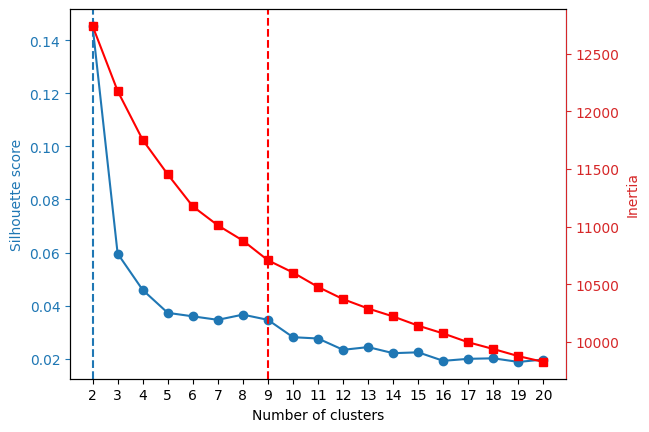

In [17]:
x = range(2, 21)

fig, ax = plt.subplots()

# First y-axis
ax.plot(x, sil_scores, marker='o')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.tick_params(axis='y')

ax.set_xticks(range(2, 21))

ax.axvline(optimal_k, linestyle='--', color='r')
ax.axvline(best_k, linestyle='--')


# Second y-axis
ax2 = ax.twinx()
ax2.plot(x, inertias, marker='s', color='r')
ax2.set_ylabel("Inertia")

# ---- Make second axis a different colour ----
axis_colour = "tab:red"

ax2.yaxis.label.set_color(axis_colour)
ax2.tick_params(axis='y', colors=axis_colour)
ax2.spines['right'].set_color(axis_colour)

# ---- Make second axis a different colour ----
axis_colour = "tab:blue"

ax.yaxis.label.set_color(axis_colour)
ax.tick_params(axis='y', colors=axis_colour)
ax.spines['right'].set_color(axis_colour)


### Assess clustering stability using the adjusted rand index

In [18]:
mean_aris = []
std_aris = []
for k in range(2,15):
    mean_ari, std_ari, _ = clustering_stability(all_embeddings, k)
    # print(f"k={k}: ARI = {mean_ari:.2f} ± {std_ari:.2f}")
    mean_aris.append(mean_ari)
    std_aris.append(std_ari)

Text(0, 0.5, 'ARI')

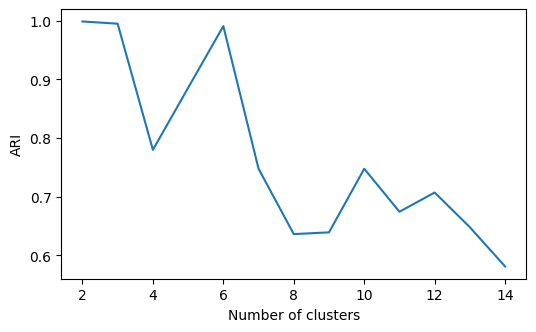

In [19]:
fig,ax=plt.subplots(figsize=(6,3.5))
ax.plot(range(2,15), mean_aris)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("ARI")

### Check UMAP low-dimensional projection

In [20]:
embeddings = np.vstack(expanded_gdf["embedding"].values)   # shape (N, 512)
             # string labels
reducer = umap.UMAP(
    n_neighbors=30, 
    min_dist=0.1, 
    metric='cosine',   # ✔ recommended for CLIP embeddings
    random_state=42)

emb_2d = reducer.fit_transform(embeddings)  # shape (N, 2)

expanded_gdf['umap_x'] = emb_2d[:, 0]
expanded_gdf['umap_y'] = emb_2d[:, 1]

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


### Plot (this code is SLOW)

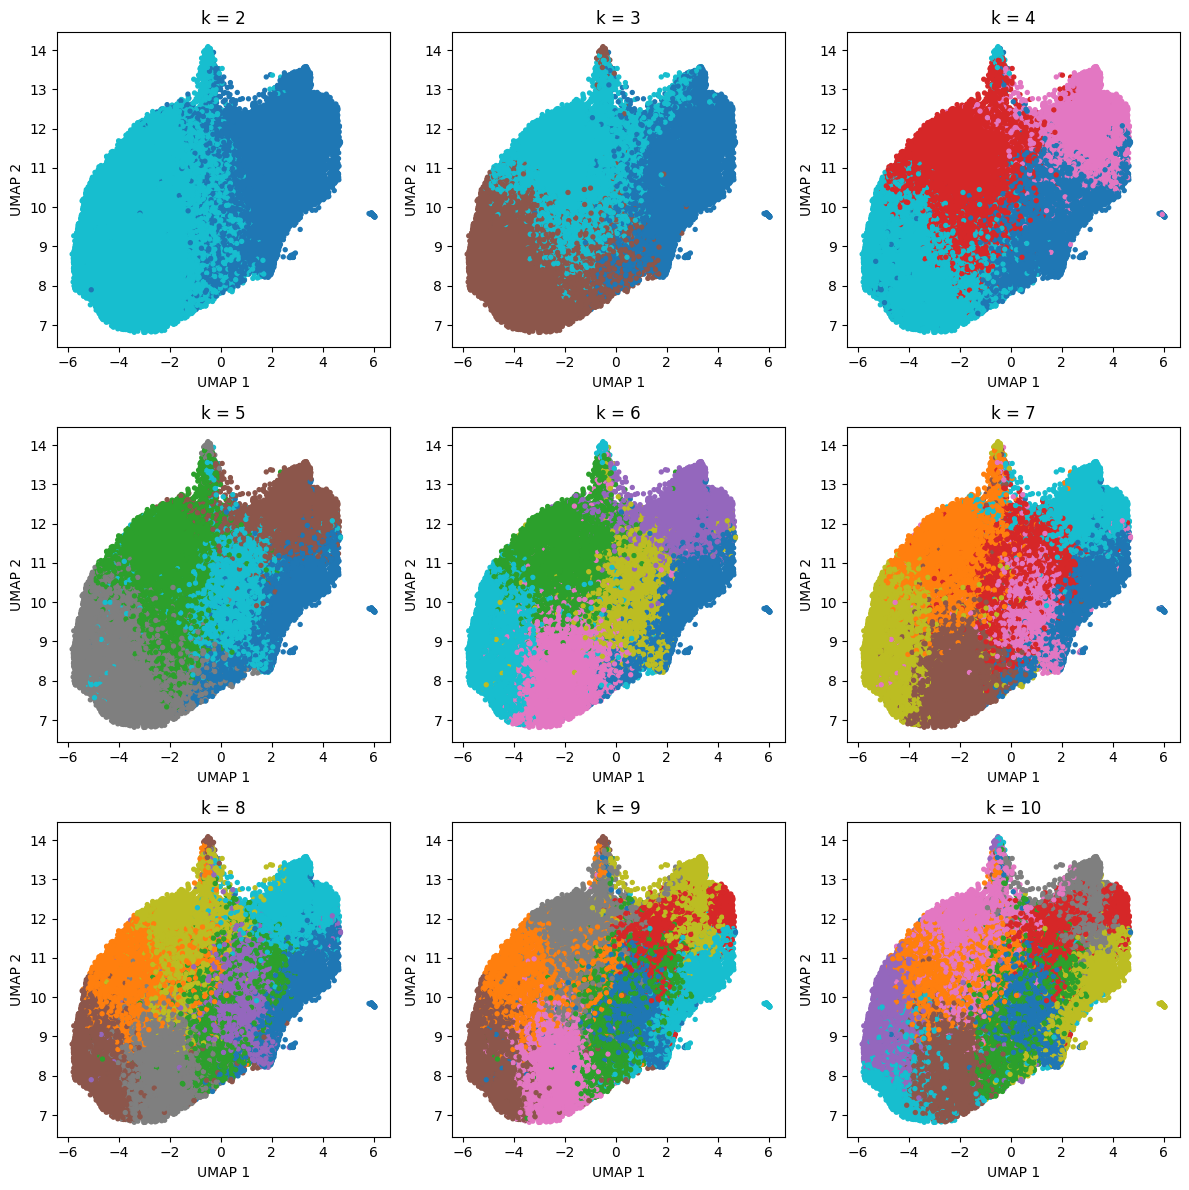

In [29]:
ks = range(2, 11)  # k = 2 to 10
n_plots = len(ks)
ncols = 3
nrows = int(np.ceil(n_plots / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axs = axs.flatten()

for i, k in enumerate(ks):
    ax = axs[i]
    labels = expanded_gdf[f'scene_cluster_{k}']

    sc = ax.scatter(expanded_gdf['umap_x'], expanded_gdf['umap_y'], c=labels, cmap='tab10', s=8)
    ax.set_title(f"k = {k}")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

# Turn off any unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

# Run cluster analysis with optimal k
Add a column to the dataframe showing which cluster the image would fall within, for cluster numbers between 2 and 10

In [25]:
for k in range(2,11):
    #print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(all_embeddings)
    expanded_gdf[f'scene_cluster_{k}'] = labels + 1    

In [1]:
del expanded_gdf['LAT'], del expanded_gdf['LONG']

### Save

In [35]:
expanded_gdf.to_pickle(data_dir + f"embedding_summaries/expanded_gdf_withclustering.pkl")

### Check the images in each cluster

In [22]:
# total_k = 7

# for this_cluster_num in range(1,total_k+1):

#     umap_df = pd.DataFrame({
#         "x": emb_2d[:, 0],
#         "y": emb_2d[:, 1],
#         "image_id": expanded_gdf["point_id"],
#         "image_files": expanded_gdf["image_files"],
#          "cluster_id": expanded_gdf[f"scene_cluster_{total_k}"],})
#     this_cluster = umap_df[umap_df["cluster_id"]==this_cluster_num]

#     image_files = this_cluster["image_files"].tolist()

#     n_images = 54

#     # Load images
#     image_files_sample =random.sample(image_files, k=n_images)
#     images = [Image.open(f) for f in image_files_sample]

#     # Define grid size
#     cols = 7  # number of columns in grid
#     rows = ceil(n_images / cols)

#     # Create figure
#     fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
#     axes = axes.flatten()

#     # Plot images
#     for ax, img in zip(axes, images):
#         ax.imshow(img)
#         ax.axis('off')

#     # Turn off any extra axes
#     for ax in axes[n_images:]:
#         ax.axis('off')
        
#     fig.suptitle(this_cluster_num)

#     plt.tight_layout()
#     plt.show()